# Laboratorio 2 - Regresión

A continuación presentamos nuestro mejor acercamiento para resolver el caso de MotorAlpes

### Librerias

Para empezar, importamos las librerías que utilizaremos

In [1]:
# Importamos las librerias que se usaran para el proyecto
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load

from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.svm import SVC

from sklearn.metrics import mean_squared_error as mse

### Carga datos

Carga de los datos históricos con los que se entrenará al modelo. 
Como se puede observar, estos datos cuentan con la columna "selling_price" la cual será el feature que se quiere encontrar a partir del modelo entrenado para el caso de los datos nuevos.

In [2]:
df_original = pd.read_csv('./data/MotorAlpes_data.csv')
raw = df_original.copy()

In [3]:
a = pd.read_csv('./data/MotorAlpes_data.csv')

In [4]:
raw = raw.dropna(subset=["selling_price"])

Además, al ser selling_price nuestra columna objetivo, eliminamos los datos nulos de esta. Esto ya que el entrenamiento del m odelo no admite datos nulos en al ser entrenado

### Entendimiento

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6714 entries, 0 to 7114
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     6714 non-null   int64  
 1   year           6486 non-null   float64
 2   km_driven      6526 non-null   float64
 3   owner          6486 non-null   object 
 4   seller_type    6714 non-null   object 
 5   seats          6714 non-null   float64
 6   fuel           6714 non-null   object 
 7   transmission   6714 non-null   object 
 8   mileage        6526 non-null   float64
 9   engine         6444 non-null   float64
 10  max_power      6456 non-null   float64
 11  selling_price  6714 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 681.9+ KB


Como se puede observar, hay una gran cantidad de columnas con valores numéricos, lo que a primera vista puede parecer adecuado para usar como features para el entrenamiento del modelo. Sin embargo, no hay que descartar las variables de tipo object ya que pueden tener información relevante para el entrenamiento.

Por otro lado, se puede observar una columna "Unnamed" la cual es simplemente una numeración del registro. Es por esto que se considera que no tiene relación alguna con los datos.

Se usan los datos históricos en esta sección debido que los tipos de datos serán los mismos para los datos nuevos.

Finalmente se aprecia que la mayoria de las columnas no estan completas y presentan valores nullos, sin embargo, los valores faltantes no represetan mas del 5% de cada columna entonces se pueden aplicar metodos para llenar los vacios.

Es importante aclarar, que este proceso de limpieza y adecuación de datos se realizan dentro del pipeline.

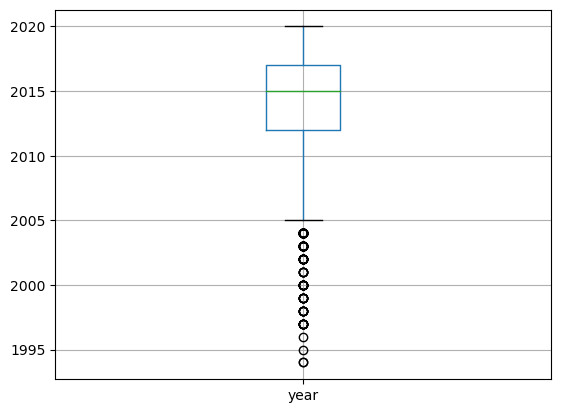

In [6]:
raw.boxplot(column='year')
plt.show()

Aquí vemos que es necesario eliminar los datos extremos para la variable año.

In [7]:
# Variables explicatvias
X = raw.drop(columns=['selling_price'])

# Variable de decision
y = raw[['selling_price']]

# Division
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

### Estadísticas generales

In [8]:
X_train.select_dtypes(include=np.number).describe()

,Unnamed: 0,year,km_driven,seats,mileage,engine,max_power
count,5035.000000,4856.000000,4.895000e+03,5035.000000,4895.000000,4839.000000,4846.000000
mean,4059.392056,2013.983114,6.950631e+04,5.405760,19.526904,1835.429634,141.328607
std,2348.037899,3.859601,6.141784e+04,0.955301,4.221072,2366.033334,274.350103
min,0.000000,1995.000000,1.000000e+03,2.000000,0.000000,4.000000,1.070000
25%,2007.500000,2012.000000,3.500000e+04,5.000000,16.800000,1197.000000,68.000000
50%,4036.000000,2015.000000,6.000000e+04,5.000000,19.330000,1248.000000,82.850000
75%,6104.500000,2017.000000,9.600000e+04,5.000000,22.320000,1591.000000,103.600000
max,8127.000000,2020.000000,2.360457e+06,14.000000,46.816000,19972.000000,1995.640000


In [9]:
X_test.select_dtypes(include=np.number).describe()

,Unnamed: 0,year,km_driven,seats,mileage,engine,max_power
count,1679.000000,1630.000000,1631.000000,1679.000000,1631.000000,1605.000000,1610.000000
mean,4062.164384,2013.987730,67710.259350,5.422871,19.552977,1854.693458,145.848814
std,2345.464711,3.871299,48399.991772,0.951055,4.327314,2410.209863,281.634488
min,1.000000,1994.000000,1.000000,4.000000,0.000000,4.000000,2.350000
25%,2062.000000,2012.000000,31377.000000,5.000000,16.800000,1197.000000,70.000000
50%,4114.000000,2015.000000,60000.000000,5.000000,19.300000,1248.000000,83.800000
75%,6057.500000,2017.000000,90000.000000,5.000000,22.370000,1598.000000,108.450000
max,8126.000000,2020.000000,380000.000000,10.000000,46.816000,19723.000000,1969.150000


### Como estan nuestros datos

In [10]:
X_train.head(1)

,Unnamed: 0,year,km_driven,owner,seller_type,seats,fuel,transmission,mileage,engine,max_power
1728,1975,2017.0,10000.0,First Owner,Individual,5.0,Petrol,Automatic,18.9,1197.0,81.86


In [11]:
X_test.head(1)

,Unnamed: 0,year,km_driven,owner,seller_type,seats,fuel,transmission,mileage,engine,max_power
1439,1649,2008.0,128000.0,First Owner,Individual,5.0,Petrol,Manual,0.0,1086.0,62.0


### Valores nulos

Se realiza un conteo de valores nulos para entender a mayor profundidad los datos proporcionados

In [12]:
X_train.isna().sum()

Unnamed: 0        0
year            179
km_driven       140
owner           179
seller_type       0
seats             0
fuel              0
transmission      0
mileage         140
engine          196
max_power       189
dtype: int64

In [13]:
X_test.isna().sum()

Unnamed: 0       0
year            49
km_driven       48
owner           49
seller_type      0
seats            0
fuel             0
transmission     0
mileage         48
engine          74
max_power       69
dtype: int64

### Correlación entre variables

In [14]:
raw.select_dtypes(include=np.number).corr()

,Unnamed: 0,year,km_driven,seats,mileage,engine,max_power,selling_price
Unnamed: 0,1.000000,0.003151,0.010194,-0.018011,0.020083,0.008964,-0.008447,-0.005223
year,0.003151,1.000000,-0.419177,-0.015016,0.311537,-0.003238,0.059415,0.106258
km_driven,0.010194,-0.419177,1.000000,0.222831,-0.159854,0.037390,-0.007648,-0.058903
seats,-0.018011,-0.015016,0.222831,1.000000,-0.436438,0.119522,0.024754,0.014288
mileage,0.020083,0.311537,-0.159854,-0.436438,1.000000,-0.120993,-0.037468,-0.025673
engine,0.008964,-0.003238,0.037390,0.119522,-0.120993,1.000000,0.000005,0.034228
max_power,-0.008447,0.059415,-0.007648,0.024754,-0.037468,0.000005,1.000000,0.016089
selling_price,-0.005223,0.106258,-0.058903,0.014288,-0.025673,0.034228,0.016089,1.000000


A pesar de que la correlación es una medida que puede ayudar a conocer la relación entre dos variables, en este caso ninguna de las variables tiene una correlación suficiente como para ser tomada en cuenta respecto al "selling_price". A pesar de esto, dos de las correlaciones más altas son:"year" - "km_driven", "seats" - "mileage".

### Separacion entrenamiento y prueba

In [15]:
# Variables explicatvias
X = raw.drop(columns=['selling_price'])

# Variable de decision
y = raw[['selling_price']]

# Division
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

### Listas de variables

Creamos las variables que utilizaremos en el proceso para entrenar el modelo.

In [16]:
numeric_columns = ['year',
                   'km_driven',
                   'seats',
                   'mileage',
                   'engine',
                   'max_power']

categoric_columns = ['owner',
                    'seller_type',
                    'fuel',
                    'transmission']

not_owner_columns = ['seller_type',
                     'fuel',
                     'transmission']

not_owner_columns_2 = ['fuel',
                     'transmission']


In [17]:
owner_categories = [["Test Drive Car","First Owner","Second Owner","Third Owner","Fourth & Above Owner"]]

### Transformadores

Inicializamos los transformadores para adecuar los datos.

In [18]:
class UnnamedTransformer():
    def __init__(self,column):
        self.column=column

    def transform(self,X,y=None):
        return X.drop(self.column,axis=1)

    def fit(self, X, y=None):
        return self 

In [19]:
class Dropper():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self

In [20]:
def year_transformer(col):
    # Definiendo variables necesarias
    year_imputer = SimpleImputer(strategy='median')

    # Imputacion basica para nulls
    imputed = year_imputer.fit_transform(col)
    year_filled = pd.DataFrame(data=imputed, columns=['year'])

    # Eliminando outliers columna year [1994, 2020]
    index_year = year_filled[ (year_filled['year'] < 2005) & (year_filled['year'] > 2020) ].index
    year_filled.drop(index_year, inplace=True)

    # Aplicando el Label Encoder para 'owner'
    for index, row in year_filled.iterrows():
        year_filled.at[index,'year'] = 2023 - row['year']

    return year_filled

In [21]:
def km_driven_transformer(col):
    # Definiendo variables necesarias
    km_imputer = SimpleImputer(strategy='mean')

    # Imputacion basica para nulls
    imputed = km_imputer.fit_transform(col)
    km_filled = pd.DataFrame(data=imputed, columns=['km_driven'])

    # Aplicando el Label Encoder para 'km_driven'
    for index, row in km_filled.iterrows():
        km_filled.at[index,'km_driven'] = row['km_driven']/1000

    return km_filled

In [22]:
def mileage_transformer(col):
    # Definiendo variables necesarias
    mileage_imputer = SimpleImputer(strategy='mean')

    # Imputacion basica para nulls
    imputed = mileage_imputer.fit_transform(col)
    mileage_filled = pd.DataFrame(data=imputed, columns=['mileage'])

    # Aplicando el Label Encoder para 'mileage'
    for index, row in mileage_filled.iterrows():
        mileage_filled.at[index,'mileage'] = row['mileage']/1000

    return mileage_filled

In [23]:
def engine_transformer(col):
    # Definiendo variables necesarias
    engine_imputer = SimpleImputer(strategy='mean')

    # Imputacion basica para nulls
    imputed = engine_imputer.fit_transform(col)
    engine_filled = pd.DataFrame(data=imputed, columns=['engine'])

    # Aplicando el Label Encoder para 'engine'
    for index, row in engine_filled.iterrows():
        engine_filled.at[index,'engine'] = row['engine']/100

    return engine_filled

In [24]:
def max_power_transformer(col):
    # Definiendo variables necesarias
    power_imputer = SimpleImputer(strategy='mean')

    # Imputacion basica para nulls
    imputed = power_imputer.fit_transform(col)
    power_filled = pd.DataFrame(data=imputed, columns=['power'])

    # Aplicando el Label Encoder para 'engine'
    for index, row in power_filled.iterrows():
        power_filled.at[index,'power'] = row['power']/10

    return power_filled

In [25]:
owner_transformer = Pipeline(steps=[
       ('owner_imputer', SimpleImputer(strategy='most_frequent')),
       ('owner_transformer', OrdinalEncoder(categories=owner_categories))
])

In [26]:
categoric_not_owner_transformer = Pipeline(steps=[
       ('not_owner_imputer', SimpleImputer(strategy='most_frequent')),
       ('not_owner_transformer', OrdinalEncoder())
])

In [27]:
seats_transformer = Pipeline(steps=[
       ('numeric_imputer', SimpleImputer(strategy='median'))
])

### Pre procesamiento por columnas

In [28]:
preprocessor = ColumnTransformer(
   transformers=[
    ('year_transformer',FunctionTransformer(year_transformer,validate=False),['year']),
    ('km_driven_transformer',FunctionTransformer(km_driven_transformer,validate=False),['km_driven']),
    ('mileage_transformer',FunctionTransformer(mileage_transformer,validate=False),['mileage']),
    ('engine_transformer',FunctionTransformer(engine_transformer,validate=False),['engine']),
    ('max_power_transformer',FunctionTransformer(max_power_transformer,validate=False),['max_power']),
    ('owner_transformer',owner_transformer,['owner']),
    ('categoric_not_owner', categoric_not_owner_transformer,not_owner_columns),
    ('categoric_owner', seats_transformer,['seats'])
   ])

In [29]:
preprocessor_2 = ColumnTransformer(
   transformers=[
    ('year_transformer',FunctionTransformer(year_transformer,validate=False),['year']),
    ('km_driven_transformer',FunctionTransformer(km_driven_transformer,validate=False),['km_driven']),
    ('mileage_transformer',FunctionTransformer(mileage_transformer,validate=False),['mileage']),
    ('categoric_not_owner', categoric_not_owner_transformer,not_owner_columns_2),
   ])

In [30]:
preprocessor_3 = ColumnTransformer(
   transformers=[
    ('year_transformer',FunctionTransformer(year_transformer,validate=False),['year']),
    ('km_driven_transformer',FunctionTransformer(km_driven_transformer,validate=False),['km_driven']),
    ('mileage_transformer',FunctionTransformer(mileage_transformer,validate=False),['mileage'])
   ])

### Comprobando el df

In [31]:
all_names = ['year','km_driven','mileage','engine','max_power','owner','seller_type','fuel','transmission','seats']
pipe_preprocessor = Pipeline([("preprocessor", preprocessor), ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = all_names)))]).fit(X_train)
pipe_preprocessor.transform(X_train)

,year,km_driven,mileage,engine,max_power,owner,seller_type,fuel,transmission,seats
0,6.0,10.000,0.01890,11.970000,8.186000,1.0,1.0,3.0,0.0,5.0
1,11.0,140.000,0.01888,19.950000,18.400000,2.0,1.0,1.0,0.0,5.0
2,10.0,190.000,0.02340,18.354296,14.132861,2.0,1.0,1.0,1.0,5.0
3,4.0,30.000,0.01240,19.990000,14.790000,1.0,1.0,1.0,0.0,5.0
4,10.0,57.000,0.02290,12.480000,7.400000,1.0,1.0,1.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...
5030,7.0,120.000,0.02452,12.480000,8.850000,1.0,1.0,1.0,1.0,7.0
5031,11.0,70.000,0.02110,8.140000,5.520000,1.0,1.0,3.0,1.0,5.0
5032,5.0,26.235,0.01655,24.980000,10.500000,1.0,0.0,1.0,1.0,6.0
5033,8.0,40.000,0.01596,25.230000,6.210000,2.0,1.0,1.0,1.0,7.0


### Creacion del pipeline

Se utilizan varios Pipelines para probar distintas técnicas de regresión.

In [32]:
linear_regression = Pipeline(steps = [
                ('eliminar Unnamed:0', UnnamedTransformer(['Unnamed: 0'])),
                ('preprocessor', preprocessor),
                ('standard', StandardScaler()),
                ('linear',LinearRegression())
           ])

In [33]:
lasso_regression = Pipeline(steps = [
                ('eliminar Unnamed:0', UnnamedTransformer(['Unnamed: 0'])),
                ('preprocessor', preprocessor),
                 ('standard', StandardScaler()),
                ('lasso',Lasso(alpha=0.5))
           ])

In [34]:
ridge_regression = Pipeline(steps = [
                ('eliminar Unnamed:0', UnnamedTransformer(['Unnamed: 0'])),
                ('preprocessor', preprocessor),
                ('standard', StandardScaler()),
                ('ridge',Lasso(alpha=1.0))
           ])

In [35]:
linear_regression_2 = Pipeline(steps = [
                ('eliminar Unnamed:0', UnnamedTransformer(['Unnamed: 0'])),
                ('eliminar columnas', Dropper(['engine','max_power','owner','seller_type','seats'])),
                ('preprocessor_2', preprocessor_2),
                 ('standard', StandardScaler()),
                ('linear_2',LinearRegression())
           ])

In [36]:
linear_regression_3 = Pipeline(steps = [
                ('eliminar Unnamed:0', UnnamedTransformer(['Unnamed: 0'])),
                ('eliminar columnas', Dropper(['engine','max_power','owner','seller_type','fuel','transmission','seats'])),
                ('preprocessor_3', preprocessor_3),
                 ('standard', StandardScaler()),
                ('linear_3',LinearRegression())
           ])

In [37]:
linear_model = linear_regression.fit(X_train, y_train)
lasso_model = lasso_regression.fit(X_train, y_train)
ridge_model = ridge_regression.fit(X_train,y_train)
linear_model_2 = linear_regression_2.fit(X_train, y_train)
linear_model_3 = linear_regression_3.fit(X_train, y_train)


### Exportacion

In [38]:
dump(linear_regression, "modelo.joblib")

['linear_regression.joblib']

### Pruebas

In [39]:
linear_predictions = linear_model.predict(X_test)
print (f"El R^2 es de: {r2_score(y_test, linear_predictions)}")
print (f"El error cuadratico medio es de: {mean_squared_error(y_test, linear_predictions)}")

El R^2 es de: 0.05010871898722602
El error cuadratico medio es de: 1201911617.7700531


In [40]:
lasso_predictions = lasso_model.predict(X_test)
print (f"El R^2 es de: {r2_score(y_test, lasso_predictions)}")
print (f"El error cuadratico medio es de: {mean_squared_error(y_test, lasso_predictions)}")

El R^2 es de: 0.05010777014973411
El error cuadratico medio es de: 1201912818.3482957


In [41]:
linear_predictions_2 = linear_model_2.predict(X_test)
print (f"El R^2 es de: {r2_score(y_test, linear_predictions_2)}")
print (f"El error cuadratico medio es de: {mean_squared_error(y_test, linear_predictions_2)}")

El R^2 es de: 0.04846326029332915
El error cuadratico medio es de: 1203993641.2187226


In [42]:
ridge_predictions = ridge_model.predict(X_test)
print (f"El R^2 es de: {r2_score(y_test, ridge_predictions)}")
print (f"El error cuadratico medio es de: {mean_squared_error(y_test, ridge_predictions)}")

El R^2 es de: 0.05010680617727559
El error cuadratico medio es de: 1201914038.0770376


In [43]:
linear_predictions_3 = linear_model_3.predict(X_test)
print (f"El R^2 es de: {r2_score(y_test, linear_predictions_3)}")
print (f"El error cuadratico medio es de: {mean_squared_error(y_test, linear_predictions_3)}")

El R^2 es de: 0.020561766434964435
El error cuadratico medio es de: 1239297817.9090836


### Supuestos

In [44]:
pd.DataFrame({'columns':['year','km_driven','mileage','engine','max_power','owner','seller_type','fuel','transmission','seats'], 'coef':(linear_regression['linear'].coef_).tolist()[0]})

,columns,coef
0,year,-2984.062608
1,km_driven,-754.753441
2,mileage,-1320.239453
3,engine,513.313799
4,max_power,-22.814581
5,owner,-125.079923
6,seller_type,-711.063270
7,fuel,-1841.594190
8,transmission,-4581.563374
9,seats,264.335048


In [45]:
pd.DataFrame({'columns':['year','km_driven','mileage'], 'coef':(linear_regression_3['linear_3'].coef_).tolist()[0]})


,columns,coef
0,year,-4696.792718
1,km_driven,-689.942552
2,mileage,-2692.662232
